In this document, we show how to use a regression model to make fault detection. The basic idea is to calculate the residual error of the regression model prediction and the measurement value. If the residual error is large, it means that the model prediction is not accurate and the measurement value is likely to be faulty.

## Prepare data

First, we read all the data and apply a simply outlier removal by validity range.

In [30]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

Then, we use all the normal tests as training data, and use these data to fit a regression model.

In [31]:
from utility import extract_selected_feature, prepare_sliding_window

# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

# Select the features.
# Use all the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
# Prepare feature and response of the training dataset.
x_tr, y_temp_tr = extract_selected_feature(df_data=df_tr, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')
# Enrich the features based on the sliding window.
window_size = 20
x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr, y=y_temp_tr, sequence_name_list=normal_test_id, window_size=window_size, mdl_type='reg')

## Fit the regression model

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)
# Fit the model
mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

## KNN regression

In [33]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn import neighbors

# knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
# # Define the steps of the pipeline
# steps = [
#     ('standardizer', StandardScaler()),  # Step 1: StandardScaler
#     ('regressor', knn)    # Step 2: Linear Regression
# ]

# # Create the pipeline
# mdl_linear_regreession = Pipeline(steps)
# # Fit the model
# mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

## Prepare testing data

In [34]:
# We use all the sequence from motor 6 with failure labels as test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]
df_test = df_data[df_data['test_condition'].isin(test_id)]

# Get labels.
x_test, y_label_test = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
_, y_label_test = prepare_sliding_window(df_x=x_test, y=y_label_test, sequence_name_list=test_id, window_size=window_size, mdl_type='clf')

# Prepare test data.
x_test, y_temp_test = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')
x_test, y_temp_test = prepare_sliding_window(df_x=x_test, y=y_temp_test, sequence_name_list=test_id, window_size=window_size, mdl_type='reg')

## Making prediction


 New cv run:

Training performance, max error is: 1.9266429932063218
Training performance, mean root square error is: 0.29461909581093415
Training performance, residual error > 3: 0.0%


Prediction performance, max error is: 8.690527275599674
Prediction performance, mean root square error is: 0.7558745046463783
Prediction performance, percentage of residual error > 3：1.0485651214128036%


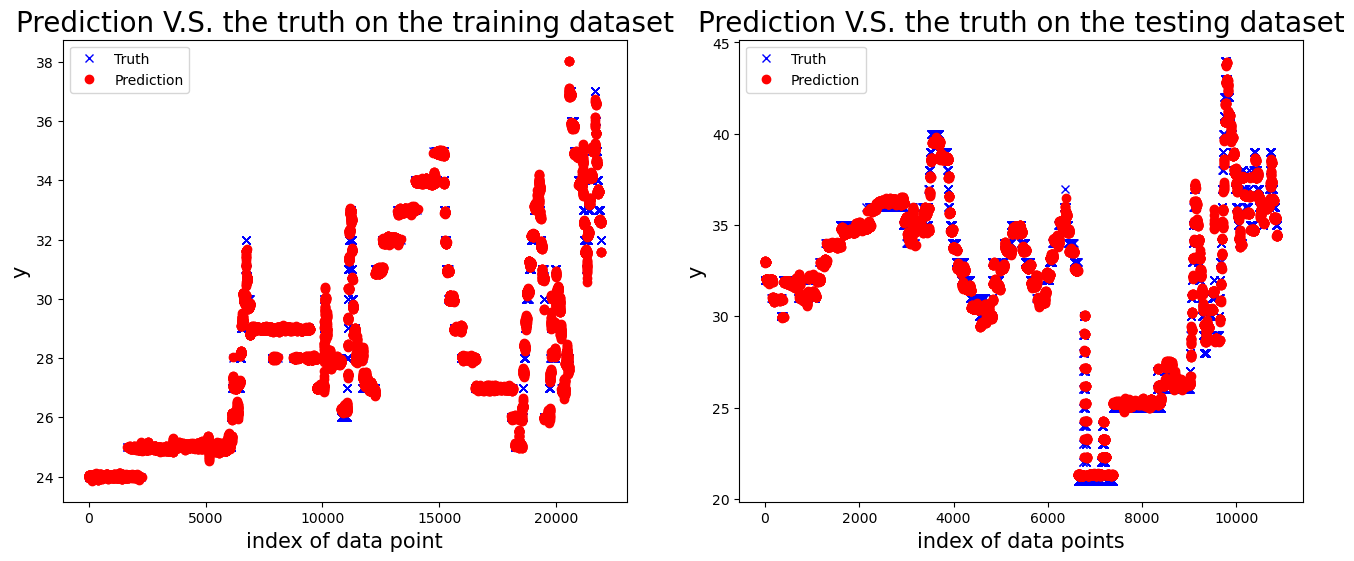

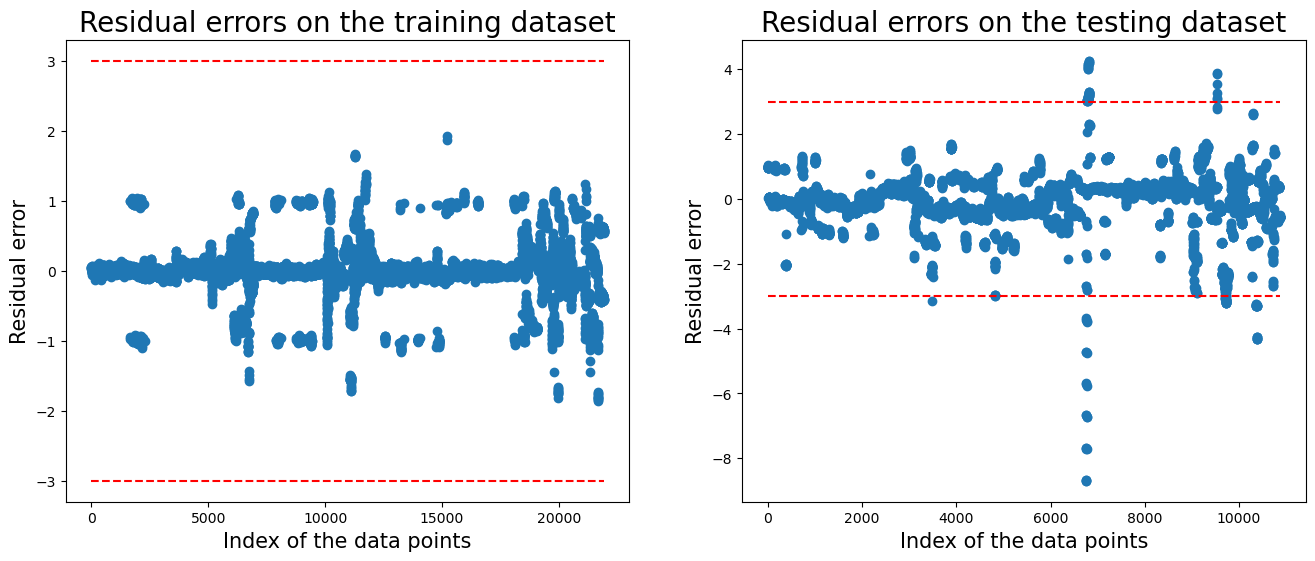

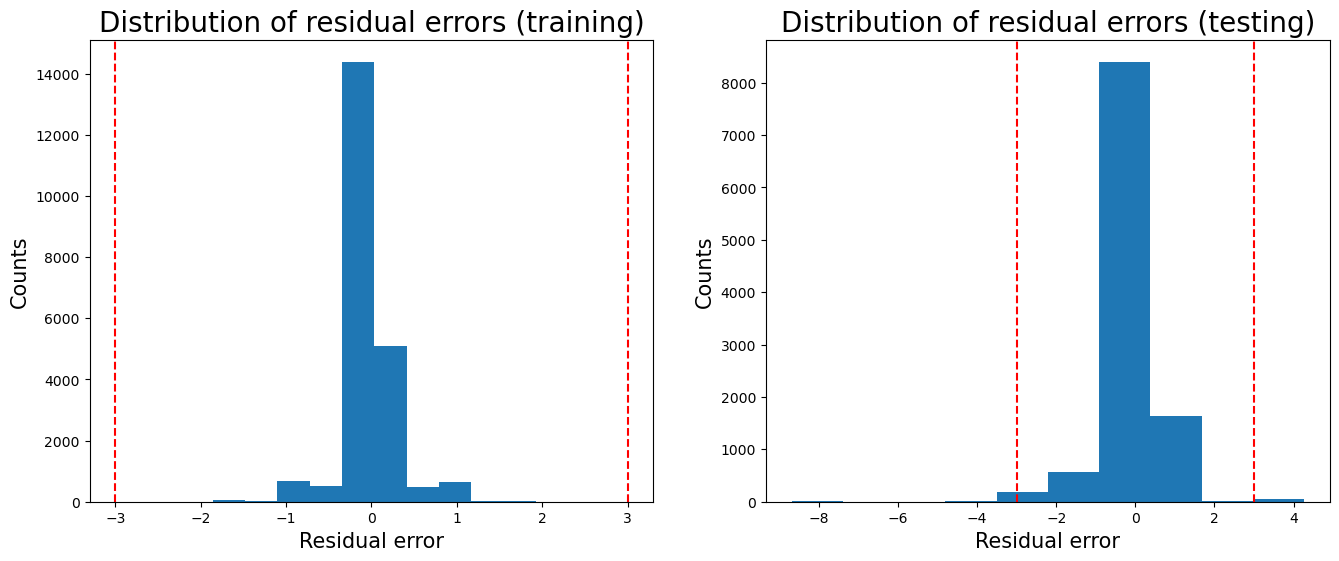

In [37]:
from utility import show_reg_result, show_clf_result
import numpy as np

def predict_label_by_reg(mdl, x, y_temp_measure, threshold=.05):
    # Predict the temperature
    y_temp_pred = mdl.predict(x)
    # Calculate the residual
    residual = np.array(abs(y_temp_pred - y_temp_measure)) 
    y_label_pred = np.where(residual <= threshold, 0, 1)

    return y_label_pred, y_temp_pred


# Predict the temperature
threshold = .5
y_label_pred_tr, y_temp_pred_tr = predict_label_by_reg(mdl, x_tr, y_temp_tr, threshold=threshold)
y_label_pred, y_temp_pred = predict_label_by_reg(mdl, x_test, y_temp_test, threshold=threshold)

show_reg_result(y_tr=y_temp_tr, y_test=y_temp_test, y_pred_tr=y_temp_pred_tr, y_pred=y_temp_pred)

In [38]:
from utility import cal_classification_perf

accuracy, precision, recall, f1 = cal_classification_perf(y_label_test, y_label_pred)
print('Prediction performance, accuracy is: ' + str(accuracy))
print('Prediction performance, precision is: ' + str(precision))
print('Prediction performance, recall is：' + str(recall))
print('Prediction performance, F1 is：' + str(f1))

Prediction performance, accuracy is: 0.7660963944076526
Prediction performance, precision is: 0.38245479030396307
Prediction performance, recall is：0.5144927536231884
Prediction performance, F1 is：0.4387552416685058
